# Cardiotocography Analysis
#### Ben Ries-Roncalli
#### June 3, 2023

In [17]:
import pandas as pd;
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [18]:
df_complete = pd.read_excel("CTG.xls", sheet_name=2)
df = df_complete.iloc[1:-3, 3:].drop(columns=['b','e', 'DR','LBE', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'])

X = df.drop(columns=['CLASS', 'NSP']).copy()
Y = df['NSP'].copy()
print(*list(X.columns))
print(len(X.columns))

LB AC FM UC ASTV MSTV ALTV MLTV DL DS DP Width Min Max Nmax Nzeros Mode Mean Median Variance Tendency
21


## Data Exploration

Notice that all columns in $X$ are numerical. First, let's look at the rate of the 3 classes to see if we have any dominating classes.

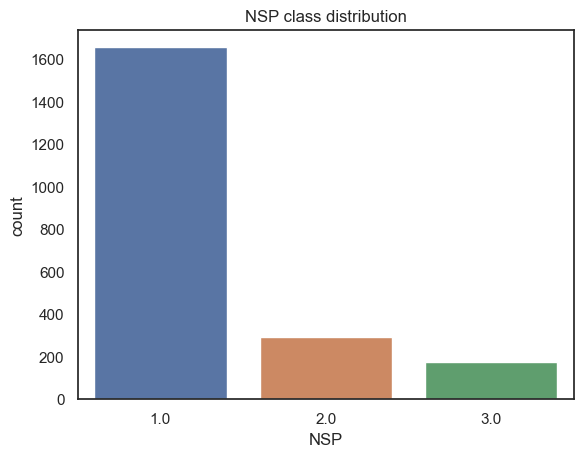

In [19]:
NSP_pie = Y.value_counts()
NSP_labels = list(NSP_pie.keys())
NSP_pct = [NSP_pie[k] for k in NSP_labels]
colors = sns.color_palette('pastel')[0:5] #define Seaborn color palette to use
sns.countplot(df, x="NSP")
plt.title("NSP class distribution")
plt.show()

Here we see that the fetal state 1 dominates the other two classes. This means we may see a model predicting with high accuracy when it may be distinguishing very little (a null model predicting 1 every time would give ~78% accuracy). In other words, we might want to also look at precision and recall values for our predictions since these might give more insight into how well we predict all the classes.

Now, let's look at how the NSP classes are distributed over each feature.

/var/folders/5k/s1jp6yp50mqb22njmlpnbs440000gn/T/ipykernel_21424/2001949779.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue="NSP", cut=0, fill=True, common_norm=False, alpha=0.4)


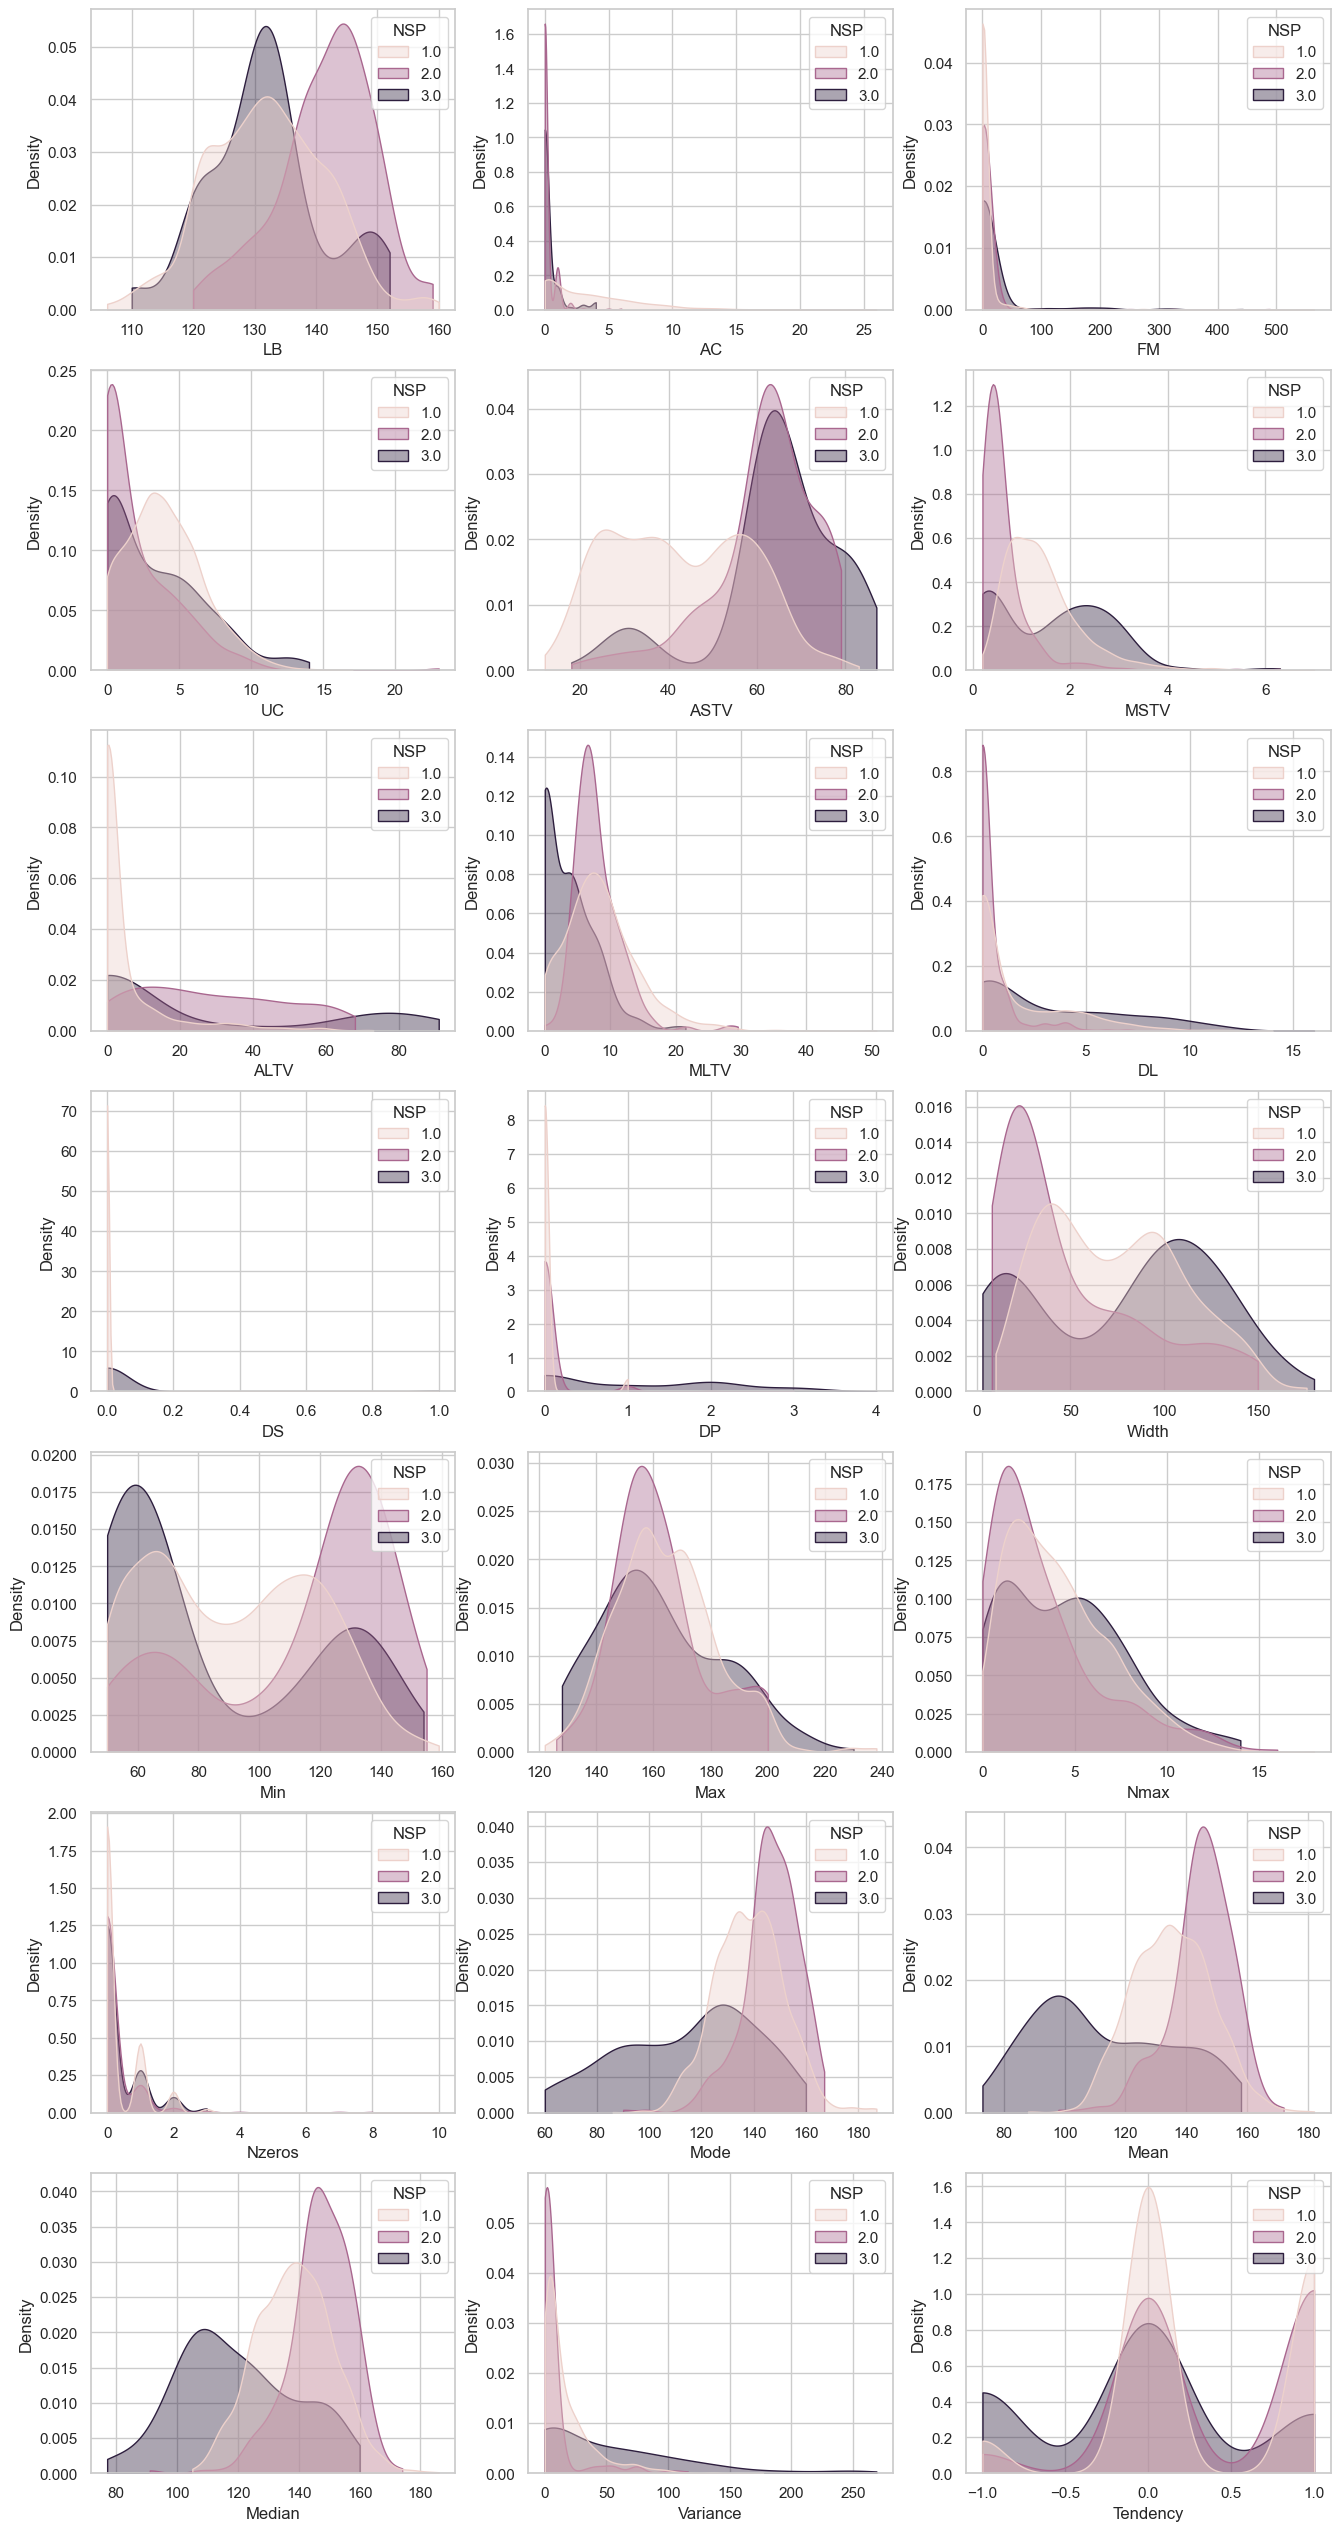

In [20]:
# set seaborn whitegrid theme
sns.set(style="whitegrid")

fig, ax = plt.subplots(7,3, figsize=(16, 32))
for i, col in enumerate(X.columns):
    plt.subplot(7,3, i+1)
    sns.kdeplot(data=df, x=col, hue="NSP", cut=0, fill=True, common_norm=False, alpha=0.4)

Some of these look like they might help us to separate out the NSP classes. Together, this might help us make some good predictions. However, a couple of these don't seem like they'd be useful predictors since they don't discriminate between the NSP classes. This means it might be useful reduce our dimensionality. Later on with our models, we'll try a number of different methods to see ways to do this.

Now, we might want to normalize our feature data. One method to accomplish this is to try Z-score standardization of the features, which we'll use.

In [21]:
from sklearn.preprocessing import StandardScaler

# fit and transform the data
std_scaler = StandardScaler()
X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
X_std.describe()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
count,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,...,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03,2.126000e+03
mean,1.069490e-15,-1.336863e-17,-2.673726e-17,-8.021179e-17,-7.352747e-17,6.684315e-17,-5.347452e-17,2.406354e-16,-1.069490e-16,6.684315e-18,...,-3.007942e-17,-4.679021e-17,-1.203177e-16,-1.671079e-16,2.757280e-17,1.069490e-16,-6.684315e-16,2.673726e-16,-5.347452e-17,-1.069490e-16
std,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,...,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00,1.000235e+00
min,-2.775197e+00,-7.647398e-01,-1.950961e-01,-1.285798e+00,-2.035639e+00,-1.282833e+00,-5.353613e-01,-1.455081e+00,-6.283755e-01,-5.747560e-02,...,-1.731757e+00,-1.474609e+00,-2.342558e+00,-1.379664e+00,-4.584438e-01,-4.729191e+00,-3.951945e+00,-4.223849e+00,-6.492081e-01,-2.162031e+00
25%,-7.423728e-01,-7.647398e-01,-1.950961e-01,-9.344795e-01,-8.720881e-01,-7.166031e-01,-5.353613e-01,-6.375828e-01,-6.283755e-01,-5.747560e-02,...,-8.587648e-01,-8.993760e-01,-6.703135e-01,-7.013968e-01,-4.584438e-01,-5.160773e-01,-6.164580e-01,-6.285137e-01,-5.801731e-01,-5.245255e-01
50%,-3.088439e-02,-4.838420e-01,-1.950961e-01,-2.318435e-01,1.169297e-01,-1.503732e-01,-5.353613e-01,-1.399751e-01,-6.283755e-01,-5.747560e-02,...,-7.563980e-02,-1.960840e-02,-1.128988e-01,-3.622634e-01,-4.584438e-01,9.451891e-02,8.912573e-02,6.289690e-02,-4.075856e-01,-5.245255e-01
75%,6.806040e-01,3.588517e-01,-1.412118e-01,4.707926e-01,8.150599e-01,4.158567e-01,6.270688e-02,4.642628e-01,5.722772e-01,-5.747560e-02,...,7.588376e-01,8.939964e-01,5.559989e-01,6.551369e-01,-4.584438e-01,6.440555e-01,6.664215e-01,6.851664e-01,1.792117e-01,1.112980e+00
max,2.713428e+00,6.538605e+00,1.500027e+01,6.794517e+00,2.327675e+00,6.417893e+00,4.412293e+00,7.555172e+00,5.775106e+00,1.739869e+01,...,2.812936e+00,2.213648e+00,4.123453e+00,4.724738e+00,1.370800e+01,3.025381e+00,3.039749e+00,3.312527e+00,8.635997e+00,1.112980e+00


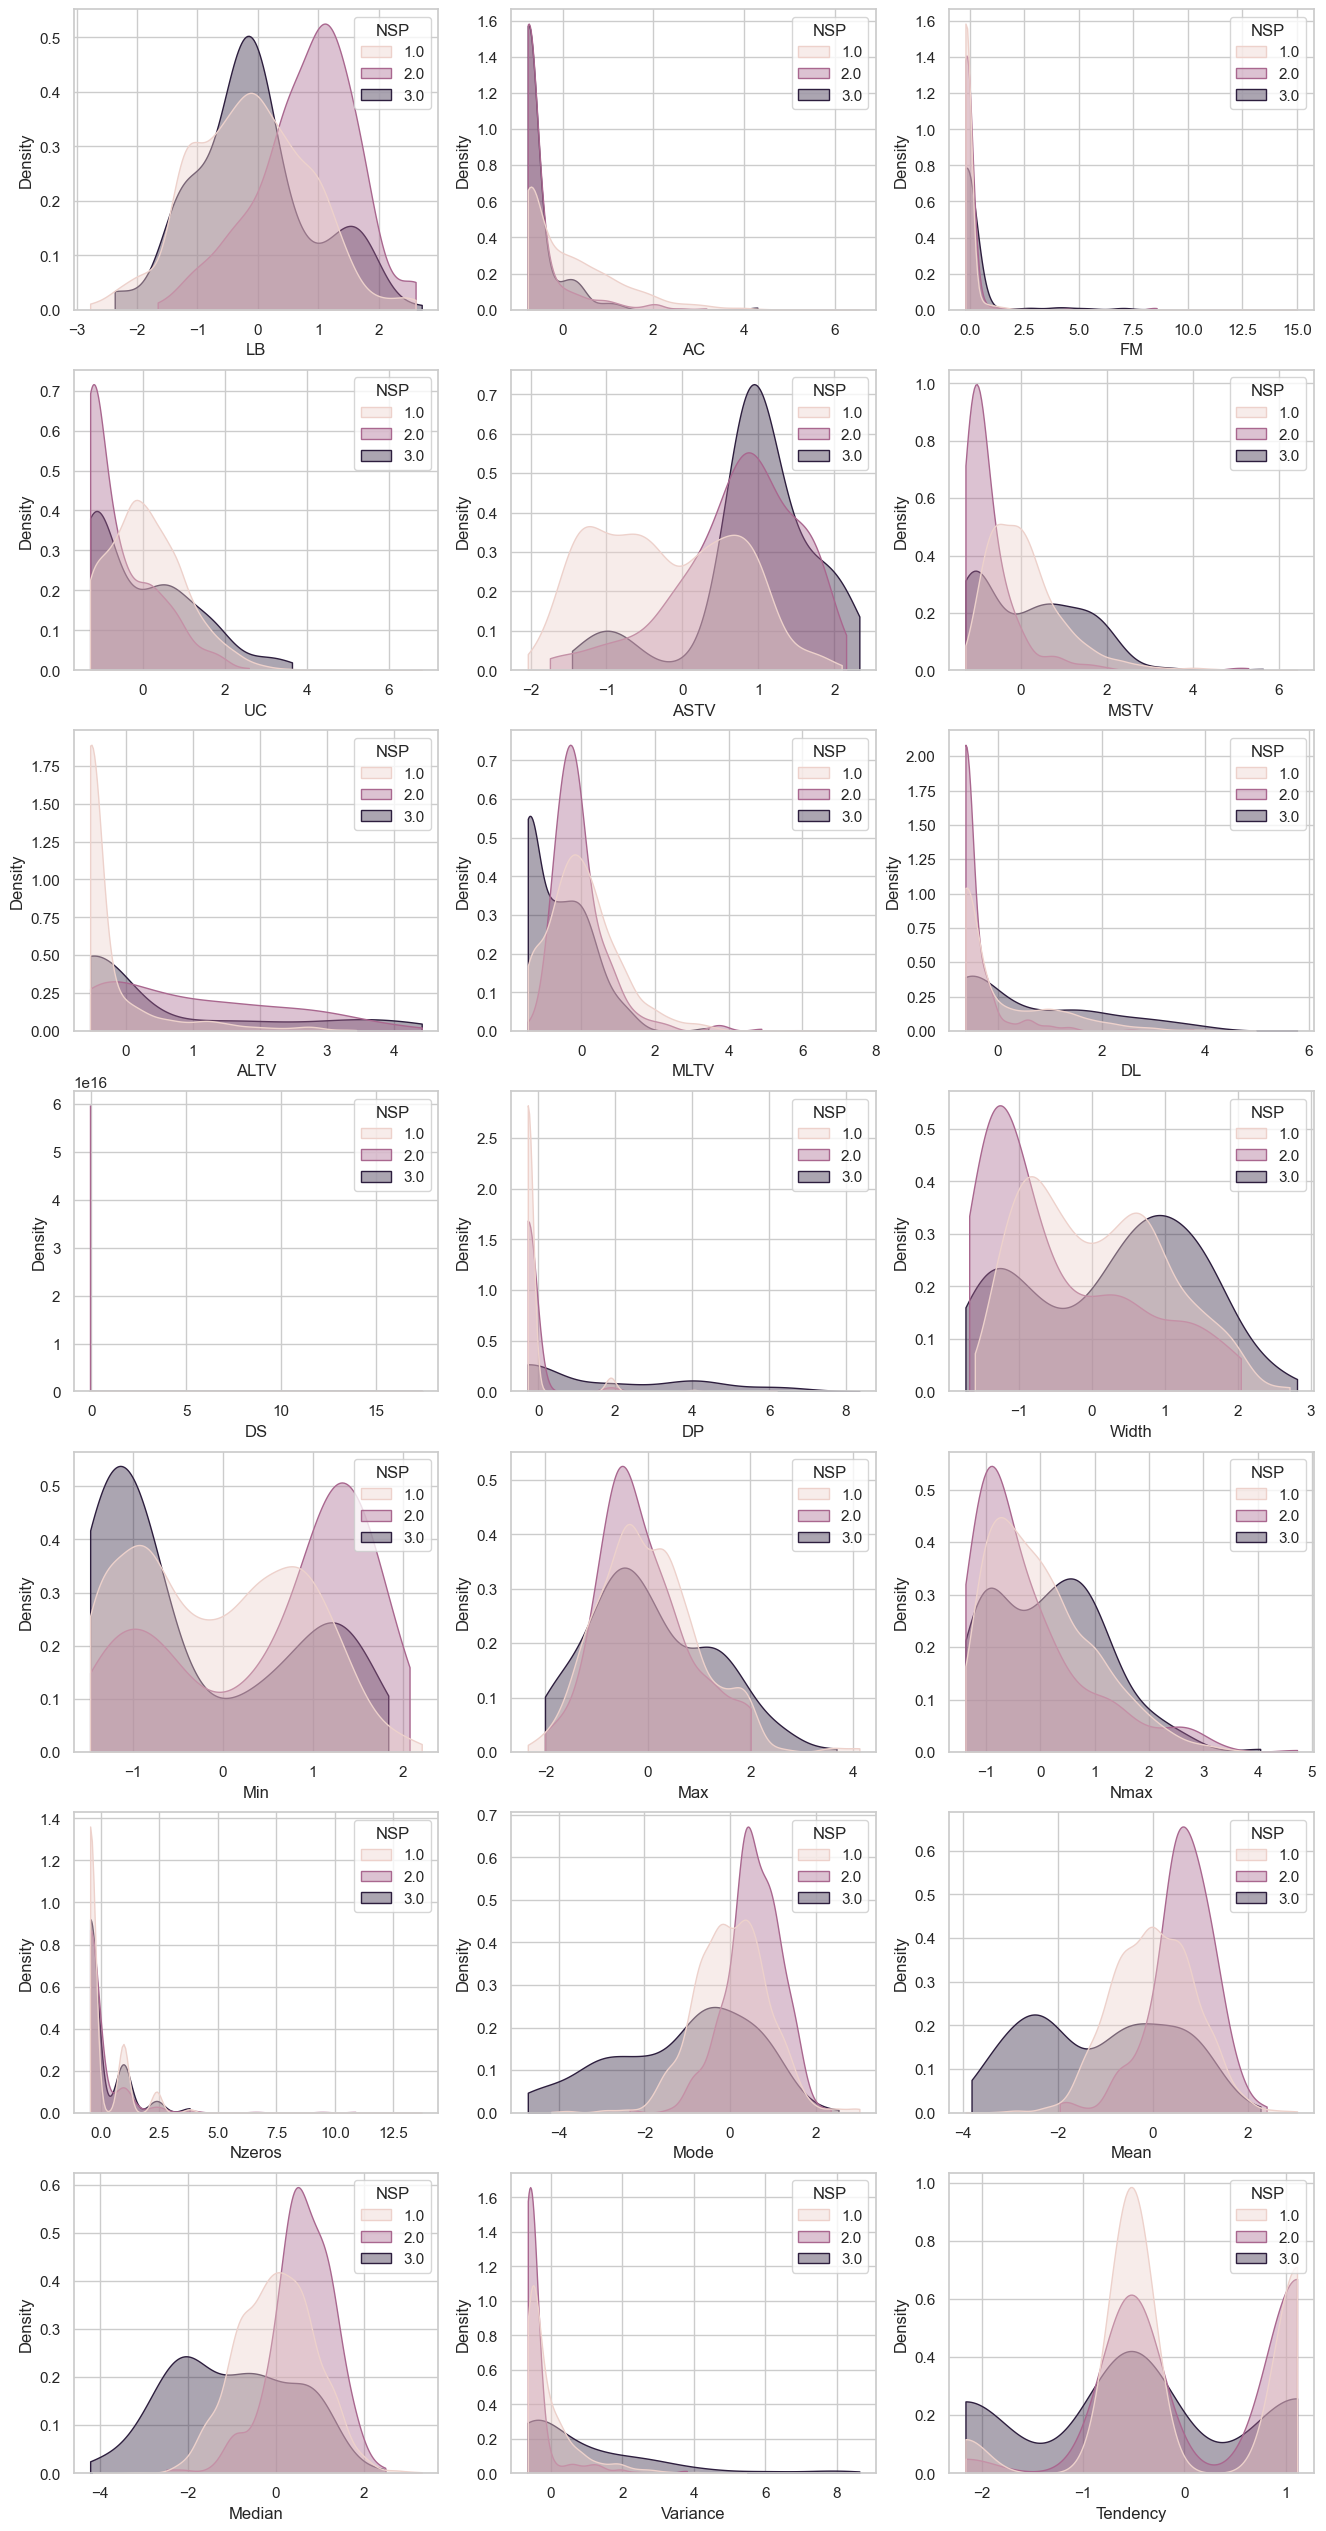

In [22]:
fig, ax = plt.subplots(7,3, figsize=(16, 32))
df_std = X_std.copy()
df_std['NSP'] = Y.copy()
for i, col in enumerate(X.columns):
    plt.subplot(7,3, i+1)
    sns.kdeplot(data=df_std, x=col, hue="NSP", cut=0, fill=True, common_norm=False, alpha=0.4)

Here we see the shape of our data is roughly preserved by the Z-score standardization. Now let's look at some correlations:

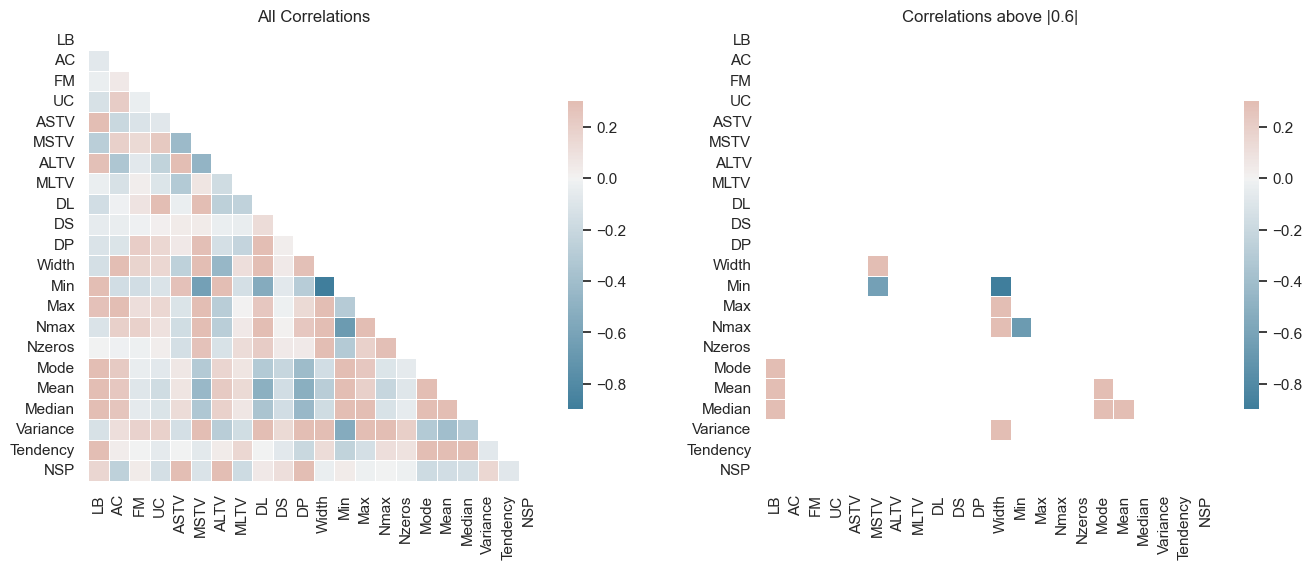

In [23]:
corr = df_std.corr() # find correlation matrix
min_correlation = 0.6
sns.set_theme(style="white") # drop background grid
mask = np.triu(np.ones_like(corr, dtype=bool)) # Generate a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True) # mask upper right triangle

fig, ax = plt.subplots(1,2, figsize=(16,8))
plt.subplot(1,2,1)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('All Correlations')
plt.subplot(1,2,2)
sns.heatmap(corr.mask(abs(corr) < min_correlation), mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title(f"Correlations above |{min_correlation}|")
plt.show()


We can see some correlations between a few feature variables, but no obvious strong correlations between any of the features and the NSP class.

Some strong correlations are:
- Width, MSTV
- Min, MSTV
- LB w/ Mode, Mean, Median
- Width w/ Min (-0.899!!), Max, Nmax
- Median, Mode Mean all somewhat correlated (not huge worry)

Before beginning our classification attempts, let's split our data into train and test splits. We'll use the `train_test_split` from the `sklearn' library. We'll reserve 20% of the data for testing and the remaining 80% for training our models. We'll also make sure our train-test split is 

In [24]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, Y, test_size=0.2, random_state=16, stratify=Y)

## Logistic Regression

Let's take a simple first attempt with logistic regression on the data. We'll use the logistic regression from sklearn w/ cross-validation built in. We'l use 10-fold stratified cross validation, L2 norm for error (default), and use the lbfgs algorithm for optimization. We will do 1000 iteration per fold, or stop iteration if the error is below 0.0001.

In [25]:
from sklearn import metrics
def conf_matrix(fitted_clf, y_true, y_pred, ax, acc, prec, rec, iteration, display):
    cm = metrics.confusion_matrix(y_true, y_pred) 
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fitted_clf.classes_)
    acc[iteration] = metrics.accuracy_score(y_true, y_pred)
    prec[iteration,:] = metrics.precision_score(y_true, y_pred, average=None)
    rec[iteration,:] = metrics.recall_score(y_true, y_pred, average=None)
    if (display):
        disp.plot(ax=ax)

def plot_learning_curve(train_sizes, train_scores, validation_scores, axesLabels):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(validation_scores, axis=1)
    test_std = np.std(validation_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    if (axesLabels):
        plt.title('Learning Curve')
        plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend()

,Model,Accuracy,Class 1 precision,Class 2 precision,Class 3 precision,Class 1 recall,Class 2 recall,Class 3 recall
0,Logistic Regression (full df),0.868545,0.927052,0.571429,0.925926,0.918675,0.677966,0.714286


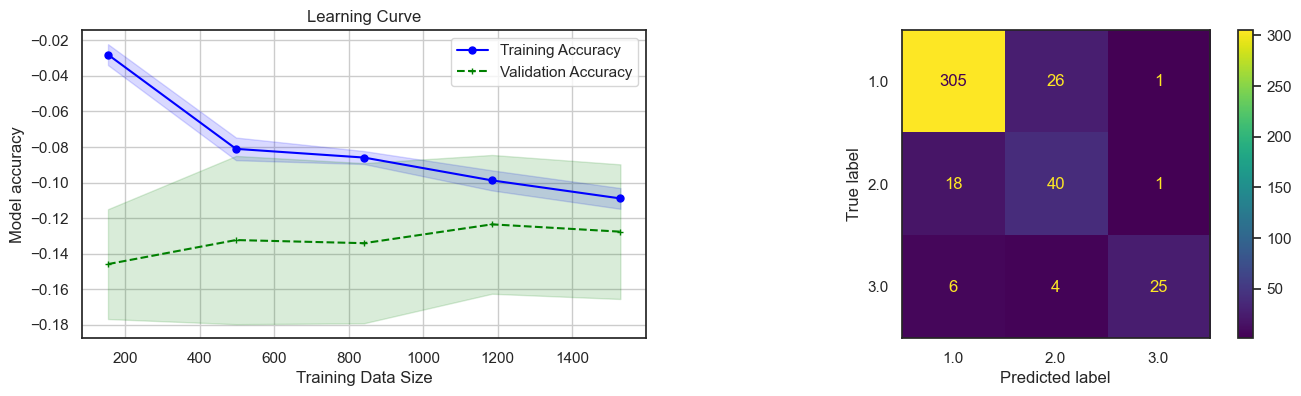

In [26]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import learning_curve

sz = (len(Y)//5)
params = { "solver": 'lbfgs', "tol": 10e-4, "max_iter": 10000 }
max_pcs = 10

accuracies = np.zeros(1)
recalls = np.ndarray((1, 3))
precisions = np.ndarray((1, 3))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
train_sizes, train_scores, validation_scores = learning_curve(estimator=LogisticRegression(**params), 
                                                                  X=X_train, y=y_train, cv=10, 
                                                                  scoring='neg_mean_squared_error')

plt.sca(ax[0])
plot_learning_curve(train_sizes, train_scores, validation_scores, axesLabels=True)
    
logr = LogisticRegressionCV(**params)
logr.fit(X_train, y_train) # do the logistic regression
y_pred = logr.predict(X_test) # predict on the test data
plt.sca(ax[1])
conf_matrix(logr, y_test, y_pred, ax[1], accuracies, precisions, recalls, 0, display=True)

model_performance = pd.DataFrame(columns=["Model", "Accuracy", "Class 1 precision", "Class 2 precision", "Class 3 precision", "Class 1 recall", "Class 2 recall", "Class 3 recall"])
model_performance.loc[0] = ["Logistic Regression (full df)", accuracies[0], *list(precisions[0]), *list(recalls[0])]
model_performance.head()

Our model seems to do a better job predicting the class 1 and struggles the most with the class 2. However, we are still able to make more accurate predictions.

## Logistic Regression with PCA
Here, we used all the columns. We have 21 columns, 2196 rows, and a 3 class prediction problem. There's a chance we might be overfitting, so let's reduce the dimensionality of our data. One way to do this is to use principal component analysis (PCA), which reorients the perspective to the intrinsic variance of the data. This reformulation can reduce the dimensionality by combining multiple features through linear combinations.

[1.00673268e+02 7.77368997e+01 5.60304900e+01 5.00120806e+01
 4.37926059e+01 4.15962580e+01 3.91210913e+01 3.76263283e+01
 3.53400332e+01 3.33682397e+01 3.21756108e+01 2.88281283e+01
 2.61162112e+01 2.37202119e+01 2.21047901e+01 2.04416968e+01
 1.57883349e+01 1.47482125e+01 9.23847048e+00 6.76947671e+00
 5.43193764e-14]


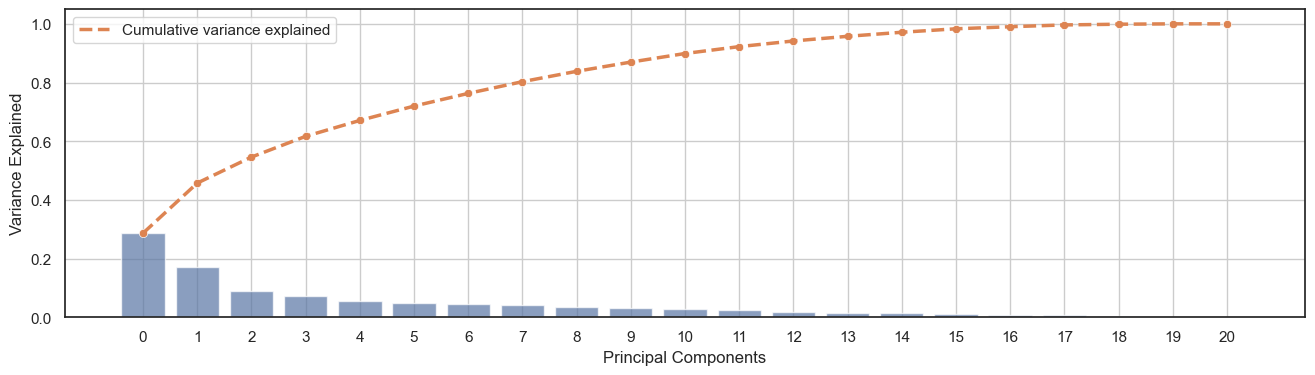

In [27]:
from sklearn.decomposition import PCA
n_components = 21
pcs = list(range(1,n_components+1))
pca = PCA(n_components=n_components, svd_solver='full')
pca.fit(X_train)
var_explained = pca.explained_variance_ratio_
cumulative_var_explained = [sum(var_explained[:i]) for i in pcs]

fig = plt.figure(figsize=(16,4))
palette = sns.color_palette()
sns.barplot(x=[pc-1 for pc in pcs], y=var_explained, color=palette[0], alpha=0.7)
line = sns.lineplot(x=[pc-1 for pc in pcs], y=cumulative_var_explained, color=palette[1], linewidth=2.5, linestyle="--", label='Cumulative variance explained')

sns.scatterplot(x=[pc-1 for pc in pcs], y=cumulative_var_explained, color=palette[1])
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.grid()
print(pca.singular_values_)

Here, we can see that PCA should allow us to reduce the dimensionality of our data, since the leading principal components explain the majority of the variance of the data. Thus, let's try training some logistic regression models on these leading coefficients only to avoid overfitting.

/Users/benjaminries-roncalli/anaconda3/envs/Data-Science/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminries-roncalli/anaconda3/envs/Data-Science/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


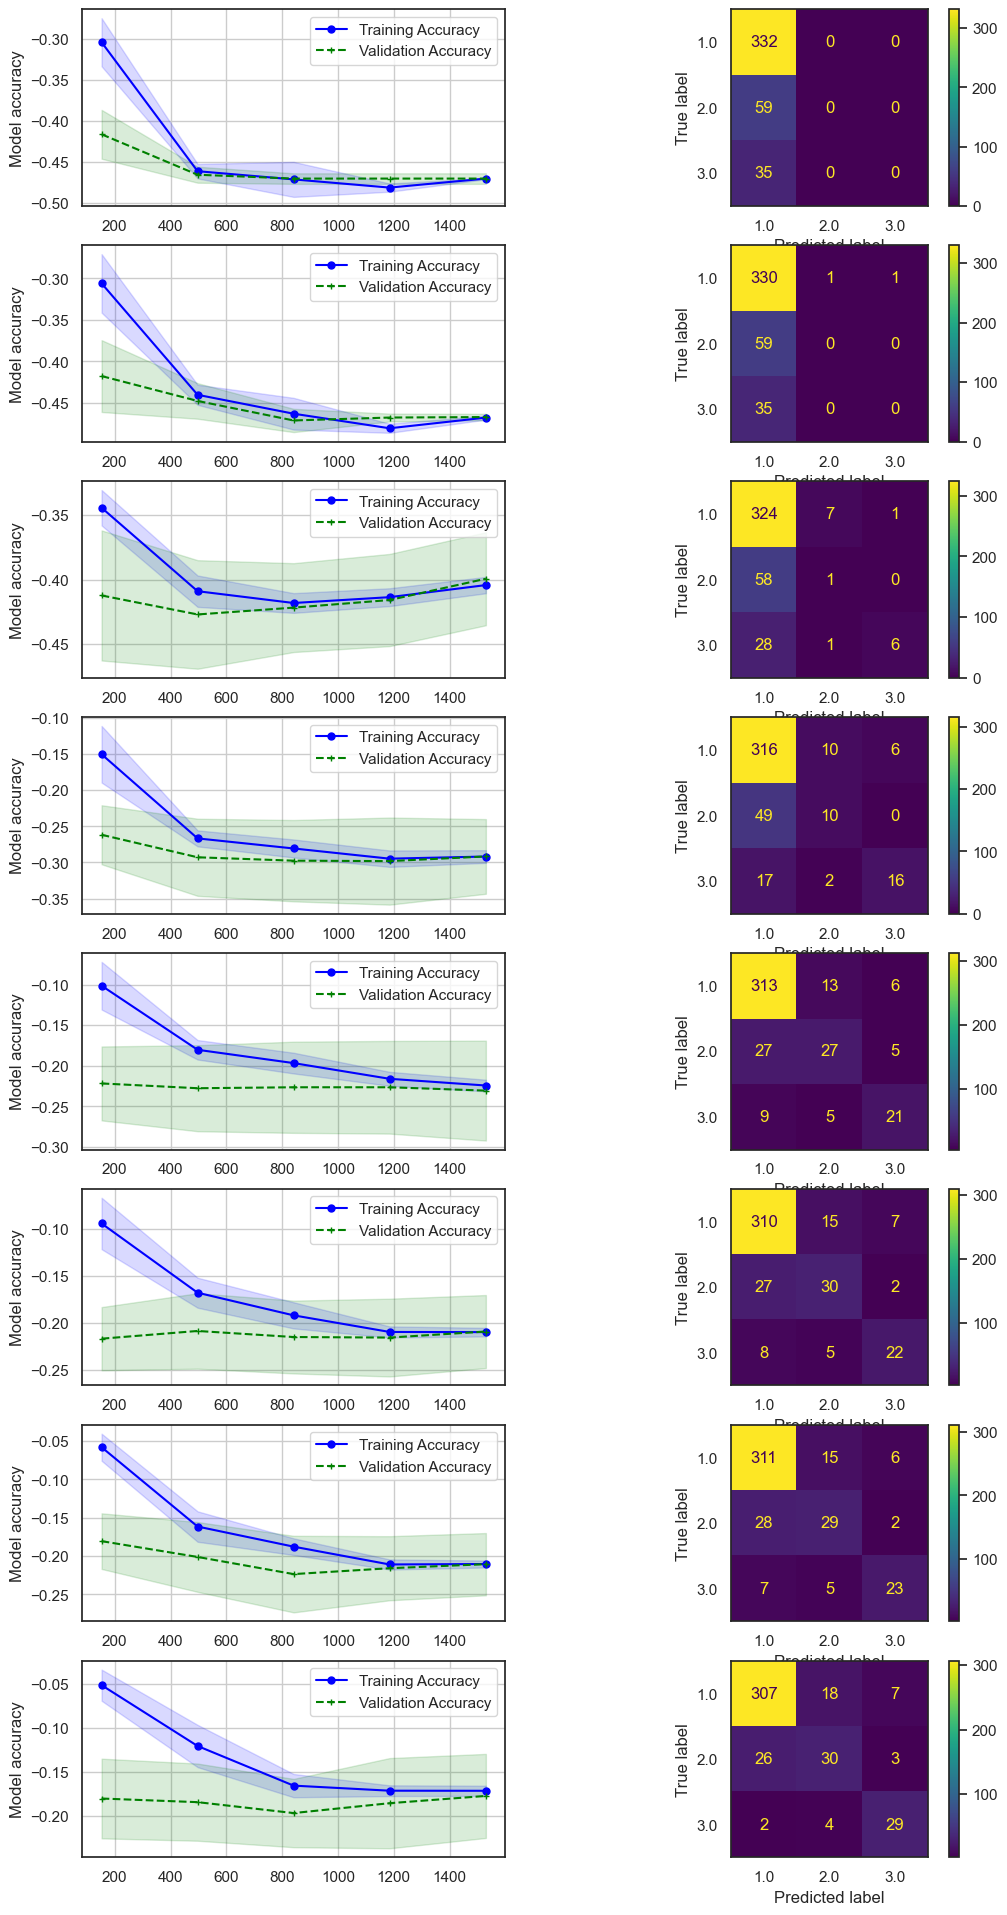

In [28]:
pca_X = pd.DataFrame(data = pca.fit_transform(X), columns = [f"pc{i}" for i in pcs])
sz = (len(Y)//5)
params = { "solver": 'lbfgs', "tol": 10e-4, "max_iter": 10000 }
max_pcs = 21
max_displayed = 8

accuracies = np.zeros(max_pcs)
recalls = np.ndarray((max_pcs, 3))
precisions = np.ndarray((max_pcs, 3))

fig, ax = plt.subplots(nrows=max_displayed, ncols=2, figsize=(12,24))
for n in range(1, max_pcs+1):
    X_trainPCA, X_testPCA, y_trainPCA, y_testPCA = train_test_split(pca_X.iloc[:,:n], Y, test_size=0.2, random_state=16, stratify=Y)
    
    train_sizes, train_scores, validation_scores = learning_curve(estimator=LogisticRegression(**params), 
                                                                  X=X_trainPCA, y=y_trainPCA, cv=10, 
                                                                  scoring='neg_mean_squared_error')
    
    if n <= max_displayed:
        plt.sca(ax[n-1, 0])
        plot_learning_curve(train_sizes, train_scores, validation_scores, axesLabels=False)
    
    logr = LogisticRegressionCV(**params)
    logr.fit(X_trainPCA, y_trainPCA) # do the logistic regression
    y_pred = logr.predict(X_testPCA) # predict on the test data
    if n <= max_displayed:
        plt.sca(ax[n-1, 1])
        conf_matrix(logr, y_testPCA, y_pred, ax[n-1, 1], accuracies, precisions, recalls, iteration=n-1, display=True)
    conf_matrix(logr, y_testPCA, y_pred, ax[0, 0], accuracies, precisions, recalls, iteration=n-1, display=False)

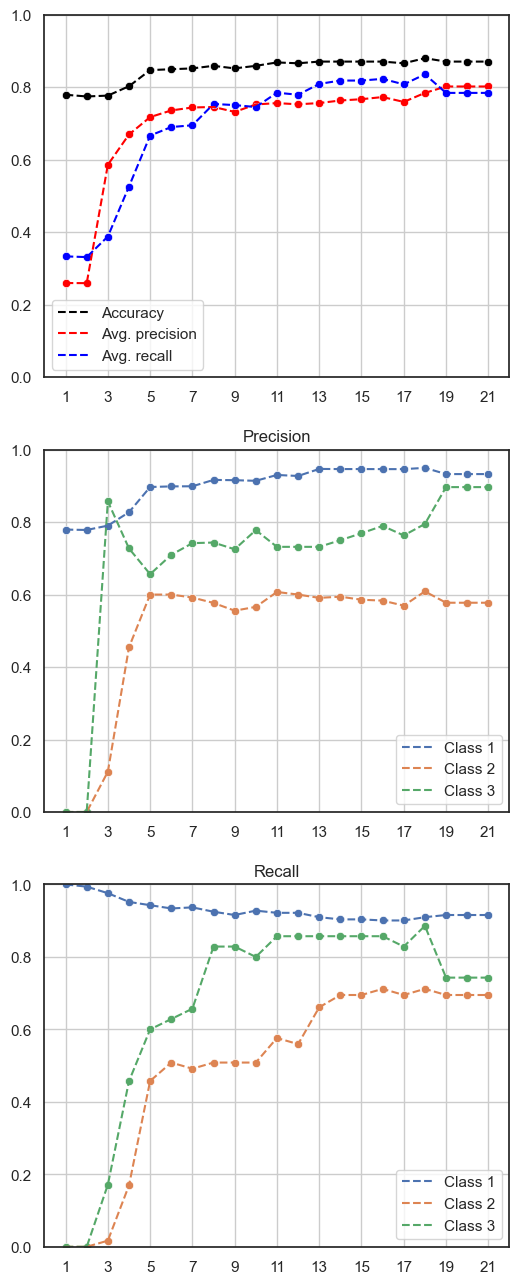

In [29]:
fig, ax = plt.subplots(3,1,figsize=(6,16))
plt.subplot(3,1,1)
sns.lineplot(x=pcs, y=accuracies, label="Accuracy", color="black", linestyle="--")
sns.lineplot(x=pcs, y=precisions.mean(axis=1), label="Avg. precision", color="red", linestyle="--")
sns.lineplot(x=pcs, y=recalls.mean(axis=1), label="Avg. recall", color="blue", linestyle="--")
sns.scatterplot(x=pcs, y=accuracies, color="black")
sns.scatterplot(x=pcs, y=precisions.mean(axis=1), color="red")
sns.scatterplot(x=pcs, y=recalls.mean(axis=1), color="blue")
plt.ylim(0,1)
plt.xticks(ticks=pcs[::2])
plt.grid()

plt.subplot(3,1,2)
plt.title("Precision")
sns.lineplot(x=pcs, y=precisions[:,0], label="Class 1", linestyle="--", color=palette[0])
sns.lineplot(x=pcs, y=precisions[:,1], label="Class 2", linestyle="--", color=palette[1])
sns.lineplot(x=pcs, y=precisions[:,2], label="Class 3", linestyle="--", color=palette[2])
sns.scatterplot(x=pcs, y=precisions[:,0], color=palette[0])
sns.scatterplot(x=pcs, y=precisions[:,1], color=palette[1])
sns.scatterplot(x=pcs, y=precisions[:,2], color=palette[2])
plt.ylim(0,1)
plt.xticks(ticks=pcs[::2])
plt.grid()

plt.subplot(3,1,3)
plt.title("Recall")
sns.lineplot(x=pcs, y=recalls[:,0], label="Class 1", linestyle="--", color=palette[0])
sns.lineplot(x=pcs, y=recalls[:,1], label="Class 2", linestyle="--", color=palette[1])
sns.lineplot(x=pcs, y=recalls[:,2], label="Class 3", linestyle="--", color=palette[2])
sns.scatterplot(x=pcs, y=recalls[:,0], color=palette[0])
sns.scatterplot(x=pcs, y=recalls[:,1], color=palette[1])
sns.scatterplot(x=pcs, y=recalls[:,2], color=palette[2])
plt.ylim(0,1)
plt.xticks(ticks=pcs[::2])
plt.grid()

From this, it's clear that the performance of our model seems to level off after only a couple principle components. As we increase the number of principle components, our accuracy obvioulsy increases, but this is primarily driven by an increase in the predictions for class 1 and class 2. The precision and recall of the class 1 remains stable and even decreases a little, but we see significant performance improvements in identifying the class 1 and 2 instances. Since this is a medical application, we might particularly care about recall, especially when it comes to identifying potential class 2 and 3 instances, which corresoond to suspect and pathologic fetal states respectively.

Let's highlight the model with the first 8 principle components, since after this the class 3 recall levels off.

,Model,Accuracy,Class 1 precision,Class 2 precision,Class 3 precision,Class 1 recall,Class 2 recall,Class 3 recall
0,Logistic Regression (full df),0.868545,0.927052,0.571429,0.925926,0.918675,0.677966,0.714286
1,Logistic Regression (PCA),0.859155,0.916418,0.576923,0.743590,0.924699,0.508475,0.828571


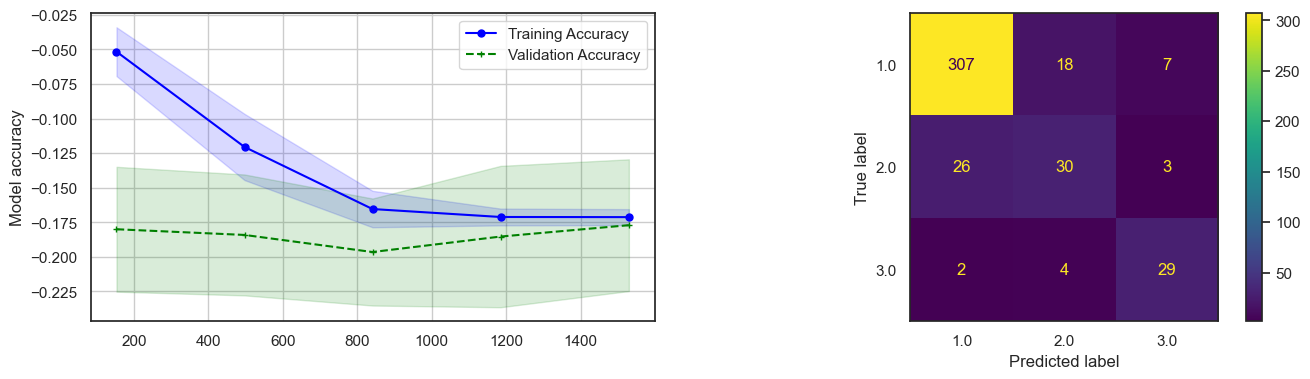

In [30]:
X_trainPCA, X_testPCA, y_trainPCA, y_testPCA = train_test_split(pca_X.iloc[:,:8], Y, test_size=0.2, random_state=16, stratify=Y)
accuracies = np.zeros(1)
recalls = np.ndarray((1, 3))
precisions = np.ndarray((1, 3))

train_sizes, train_scores, validation_scores = learning_curve(estimator=LogisticRegression(**params), 
                                                                  X=X_trainPCA, y=y_trainPCA, cv=10, 
                                                                  scoring='neg_mean_squared_error')

fig, ax = plt.subplots(1,2,figsize=(16,4))
plt.sca(ax[0])
plot_learning_curve(train_sizes, train_scores, validation_scores, axesLabels=False)
    
logr = LogisticRegressionCV(**params)
logr.fit(X_trainPCA, y_trainPCA) # do the logistic regression
y_pred = logr.predict(X_testPCA) # predict on the test data
plt.sca(ax[1])
conf_matrix(logr, y_testPCA, y_pred, ax[1], accuracies, precisions, recalls, iteration=0, display=True)

model_performance.loc[1] = ["Logistic Regression (PCA)", accuracies[0], *list(precisions[0]), *list(recalls[0])]
model_performance.head()

This model is slightly less accurate overall than our original logistic regression model with all of the columns. However, it is much simpler, less likely to be overfit, and has a better class 1 and class 2 recall than the original model. These all might be desirable for this application as mentioned before.

These logistic regression results are a good baseline. We were able to get make some pretty accurate predictions, but let's see if another approach works better.  

## Random Forest Decision Trees
We might imagine a medical professional classifying the readings from a cardioctography going through a checklist to determine the detal state (`NSP`). Decision trees follow a similar decision making process to this, so let's see if a decision tree model performs any better than a logistic regression.
We'll look at a random forest decision tree, which will be useful both in trying to improve our predictions and giving us some more insight into which variables in our data are most important.

When we do this, instead of doing a single random forest, we'll do a randomized search of our paramter space first to tune the hyperparameters of the random forest and then take the best performing decision tree. When we do this, we'll also use 10-fold cross validation.

Best hyperparameters: {'max_depth': 13, 'n_estimators': 208}


,Model,Accuracy,Class 1 precision,Class 2 precision,Class 3 precision,Class 1 recall,Class 2 recall,Class 3 recall
0,Logistic Regression (full df),0.868545,0.927052,0.571429,0.925926,0.918675,0.677966,0.714286
1,Logistic Regression (PCA),0.859155,0.916418,0.576923,0.743590,0.924699,0.508475,0.828571
2,Random Forest (full),0.938967,0.969512,0.833333,0.842105,0.957831,0.847458,0.914286


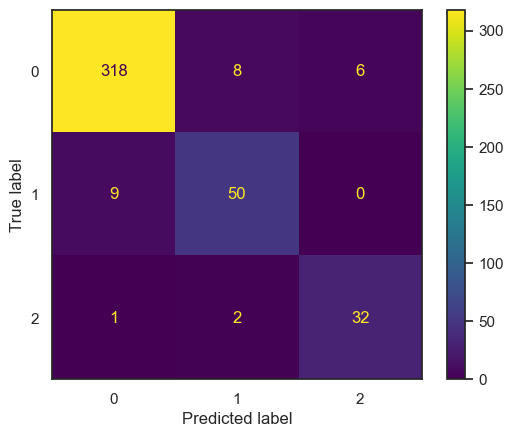

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# tune hyperparameters
param_dist = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=50, cv=10, n_jobs=-1) # Use random search to find the best hyperparameters
rand_search.fit(X_train, y_train)

# use best predictor
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)
y_pred = best_rf.predict(X_test)

#visualize results
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, average=None)
rec = metrics.recall_score(y_test, y_pred, average=None)

model_performance.loc[2] = ["Random Forest (full)", acc, *list(prec), *list(rec)]
model_performance.head()

This decision tree outperforms both logistic regressions! However, we should be careful because we may have overfit our data. This model is a bit of a black box right now, so let's look inside of it to learn how it's making its decisions. with decision trees, we can assign a relative importance to each feature based on the nodes that use it and how much data they see and partition. So, let's loook at the importance of feature in our model.

Text(0.5, 1.0, 'Feature Importance')

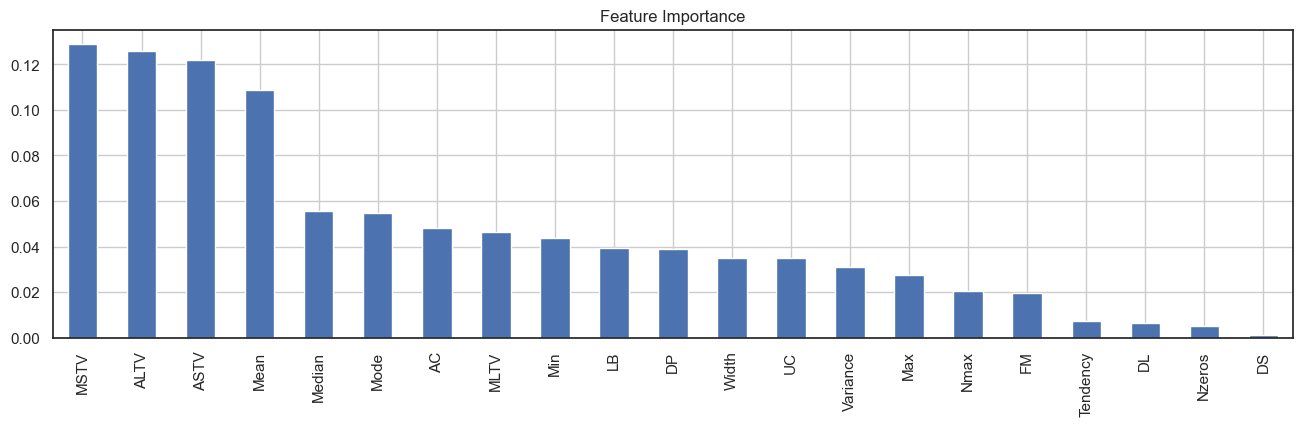

In [32]:
plt.figure(figsize=(16,4))
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar();
plt.grid()
plt.title("Feature Importance")

It seems like some features might not be too important to our decision tree. Let's see how some of the models using only the most important features perform. To do this, we'll train random forests as we did above, but now we've reduced to only 5-fold cross validation. we'll train a model on everywhere from just the most important feature to the 10 most important features and mark down their accuracy, precision, and recall to see how they perform.

In [33]:
features_importance = sorted(list(zip(best_rf.feature_importances_, X_train.columns)), reverse=True)
features = [j[1] for j in features_importance]
max_cols = 10
param_dist = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}
tree_performance = pd.DataFrame(columns=["Features", "Accuracy", "Class 1 precision", "Class 2 precision", "Class 3 precision", "Class 1 recall", "Class 2 recall", "Class 3 recall"])

for n in range(1,max_cols+1):
    del rand_search, rf, best_rf
    X_train_subset = X_train[features[:n]]
    X_test_subset = X_test[features[:n]]
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=30, cv=5, n_jobs=-1) # Use random search to find the best hyperparameters
    rand_search.fit(X_train_subset, y_train)
    
    best_rf = rand_search.best_estimator_
    print('Best hyperparameters:',  rand_search.best_params_)
    y_pred = best_rf.predict(X_test_subset)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, average=None)
    rec = metrics.recall_score(y_test, y_pred, average=None)
    tree_performance.loc[n-1] = [n, acc, *list(prec), *list(rec)]

Best hyperparameters: {'max_depth': 2, 'n_estimators': 94}


/Users/benjaminries-roncalli/anaconda3/envs/Data-Science/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best hyperparameters: {'max_depth': 2, 'n_estimators': 128}
Best hyperparameters: {'max_depth': 7, 'n_estimators': 294}
Best hyperparameters: {'max_depth': 14, 'n_estimators': 442}
Best hyperparameters: {'max_depth': 16, 'n_estimators': 236}
Best hyperparameters: {'max_depth': 12, 'n_estimators': 472}
Best hyperparameters: {'max_depth': 17, 'n_estimators': 282}
Best hyperparameters: {'max_depth': 16, 'n_estimators': 497}
Best hyperparameters: {'max_depth': 13, 'n_estimators': 359}
Best hyperparameters: {'max_depth': 14, 'n_estimators': 239}


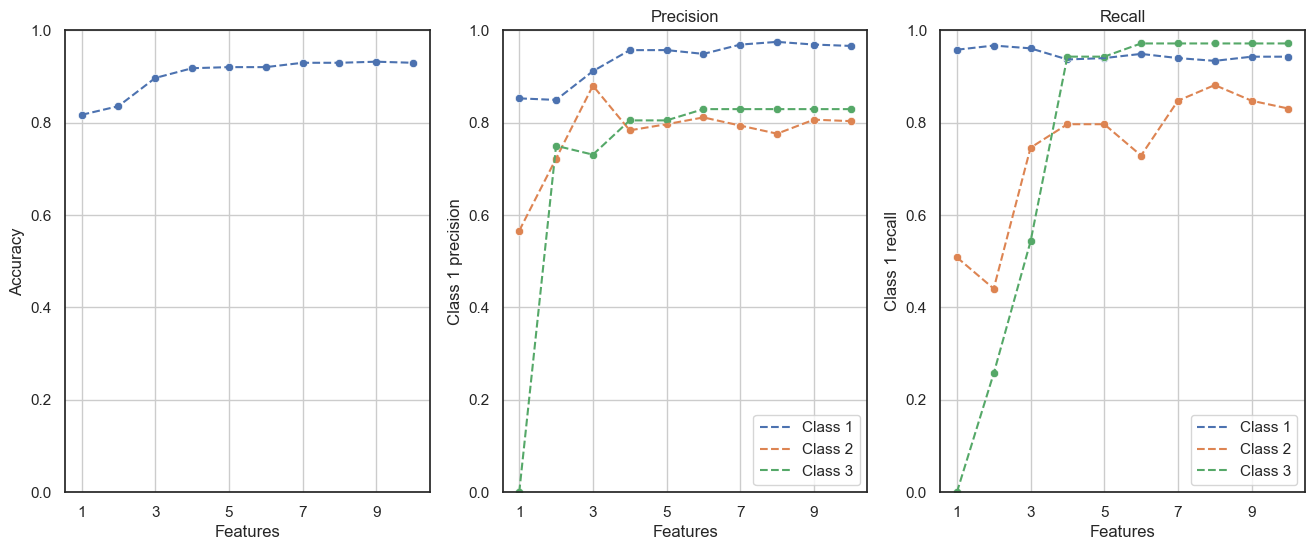

In [34]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
plt.subplot(1,3,1)
sns.lineplot(data=tree_performance, x="Features", y="Accuracy", linestyle="--")
sns.scatterplot(data=tree_performance, x="Features", y="Accuracy")
plt.ylim(0,1)
plt.xticks(ticks=pcs[:max_cols:2])
plt.grid()

plt.subplot(1,3,2)
plt.title("Precision")
sns.lineplot(data=tree_performance, x="Features", y="Class 1 precision", label="Class 1", linestyle="--", color=palette[0])
sns.lineplot(data=tree_performance, x="Features", y="Class 2 precision", label="Class 2", linestyle="--", color=palette[1])
sns.lineplot(data=tree_performance, x="Features", y="Class 3 precision", label="Class 3", linestyle="--", color=palette[2])
sns.scatterplot(data=tree_performance, x="Features", y="Class 1 precision", color=palette[0])
sns.scatterplot(data=tree_performance, x="Features", y="Class 2 precision", color=palette[1])
sns.scatterplot(data=tree_performance, x="Features", y="Class 3 precision", color=palette[2])
plt.ylim(0,1)
plt.xticks(ticks=pcs[:max_cols:2])
plt.grid()

plt.subplot(1,3,3)
plt.title("Recall")
sns.lineplot(data=tree_performance, x="Features", y="Class 1 recall", label="Class 1", linestyle="--", color=palette[0])
sns.lineplot(data=tree_performance, x="Features", y="Class 2 recall", label="Class 2", linestyle="--", color=palette[1])
sns.lineplot(data=tree_performance, x="Features", y="Class 3 recall", label="Class 3", linestyle="--", color=palette[2])
sns.scatterplot(data=tree_performance, x="Features", y="Class 1 recall", color=palette[0])
sns.scatterplot(data=tree_performance, x="Features", y="Class 2 recall", color=palette[1])
sns.scatterplot(data=tree_performance, x="Features", y="Class 3 recall", color=palette[2])
plt.ylim(0,1)
plt.xticks(ticks=pcs[:max_cols:2])
plt.grid()

Here, we can see that as we increase the number of features available to our decision trees, the performance improves on average. However, this performance improvement tails off as we add more and more features. Thus, to prevent overfitting and simplify our model, we'll take the model using 5 features as our best decision tree model, since this is where the class 3 recall is maximized before it's improvement quickly diminishes.

,Model,Accuracy,Class 1 precision,Class 2 precision,Class 3 precision,Class 1 recall,Class 2 recall,Class 3 recall
0,Logistic Regression (full df),0.868545,0.927052,0.571429,0.925926,0.918675,0.677966,0.714286
1,Logistic Regression (PCA),0.859155,0.916418,0.576923,0.743590,0.924699,0.508475,0.828571
2,Random Forest (full),0.938967,0.969512,0.833333,0.842105,0.957831,0.847458,0.914286
3,Random Forest (5 features),0.915493,0.948485,0.814815,0.785714,0.942771,0.745763,0.942857


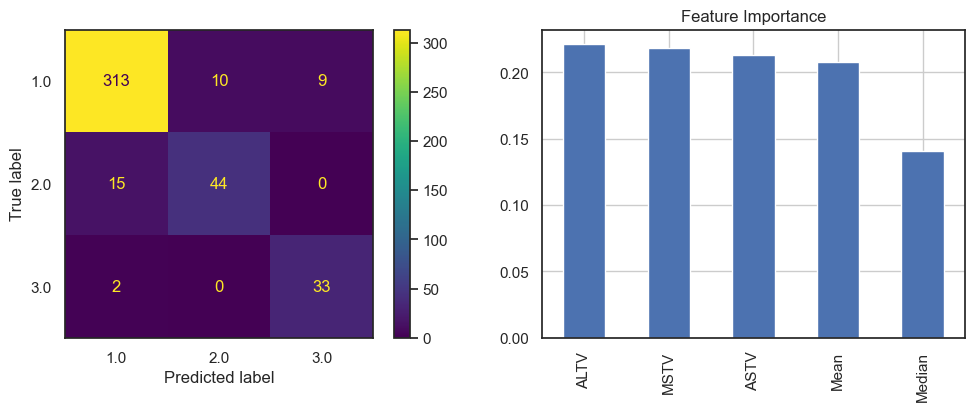

In [35]:
num_features=5
X_train_subset = X_train[features[:num_features]]
X_test_subset = X_test[features[:num_features]]
rf = RandomForestClassifier()
rf.fit(X_train_subset, y_train)
y_pred = rf.predict(X_test_subset)
acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, average=None)
rec = metrics.recall_score(y_test, y_pred, average=None)

acc = np.zeros(1)
recs = np.ndarray((1, 3))
precs = np.ndarray((1, 3))
fig, ax = plt.subplots(1,2,figsize=(12,4))
conf_matrix(logr, y_test, y_pred, ax[0], acc, precs, recs, iteration=0, display=True)

plt.sca(ax[1])
feature_importances = pd.Series(rf.feature_importances_, index=X_train_subset.columns).sort_values(ascending=False)
feature_importances.plot.bar();
plt.grid()
plt.title("Feature Importance")

model_performance.loc[3] = ["Random Forest (5 features)", acc[0], *list(precs[0]), *list(recs[0])]
model_performance.head()


Interstingly, this approach to the overfitting has given us worse perfromance across the board, it has improved the Class 3 recall on test data significantly - by almost as much as the full random forest did on the logistic regression! This is important for us since again, we want to have high recall on the pathologic fetal state. Pair this with the simpler architecture and less chance of overfitting, and this is another good improvement in our performance.

## Multilayer-Perceptron Classifier
To try to improve once more on our performance, the final model we'll apply to our classification task is a neural network. Here, we'll use a grid search of the parameter space (as opposed to the random one we did for the decision tree) to tune the models hyperparameters of a multilayer perceptron. When doing this, we'll use 10-fold cross validation.

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
param_dist = {
    'hidden_layer_sizes': [(10,), (20,), (10,10,), (10,20,), (20,10,), (10,10,10), (10,10,20), (10,20,10), (20,10,10), (10,20,20), (20,20,10), (20,20,20)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier(max_iter=10000)
grid_search = GridSearchCV(mlp, param_dist, n_jobs=-1, cv=10);
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_

,Model,Accuracy,Class 1 precision,Class 2 precision,Class 3 precision,Class 1 recall,Class 2 recall,Class 3 recall
0,Logistic Regression (full df),0.868545,0.927052,0.571429,0.925926,0.918675,0.677966,0.714286
1,Logistic Regression (PCA),0.859155,0.916418,0.576923,0.743590,0.924699,0.508475,0.828571
2,Random Forest (full),0.938967,0.969512,0.833333,0.842105,0.957831,0.847458,0.914286
3,Random Forest (5 features),0.915493,0.948485,0.814815,0.785714,0.942771,0.745763,0.942857
4,MLP (full),0.908451,0.943114,0.725806,0.900000,0.948795,0.762712,0.771429


<Figure size 800x400 with 0 Axes>

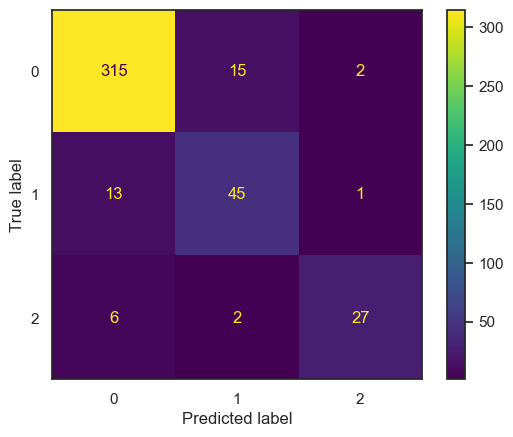

In [37]:
y_pred = best_mlp.predict(X_test)
plt.figure(figsize=(8,4))
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, average=None)
rec = metrics.recall_score(y_test, y_pred, average=None)

model_performance.loc[4] = ["MLP (full)", acc, *list(prec), *list(rec)]
model_performance.head()

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
param_dist = {
    'hidden_layer_sizes': [(10,), (20,), (10,10,), (10,20,), (20,10,), (10,10,10), (10,10,20), (10,20,10), (20,10,10), (10,20,20), (20,20,10), (20,20,20)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier(max_iter=10000)
grid_search = GridSearchCV(mlp, param_dist, n_jobs=-1, cv=10);
grid_search.fit(X_train_subset, y_train)
best_mlp = grid_search.best_estimator_

,Model,Accuracy,Class 1 precision,Class 2 precision,Class 3 precision,Class 1 recall,Class 2 recall,Class 3 recall
0,Logistic Regression (full df),0.868545,0.927052,0.571429,0.925926,0.918675,0.677966,0.714286
1,Logistic Regression (PCA),0.859155,0.916418,0.576923,0.743590,0.924699,0.508475,0.828571
2,Random Forest (full),0.938967,0.969512,0.833333,0.842105,0.957831,0.847458,0.914286
3,Random Forest (5 features),0.915493,0.948485,0.814815,0.785714,0.942771,0.745763,0.942857
4,MLP (full),0.908451,0.943114,0.725806,0.900000,0.948795,0.762712,0.771429
5,MLP (5 features),0.917840,0.962963,0.770492,0.780488,0.939759,0.796610,0.914286


<Figure size 800x400 with 0 Axes>

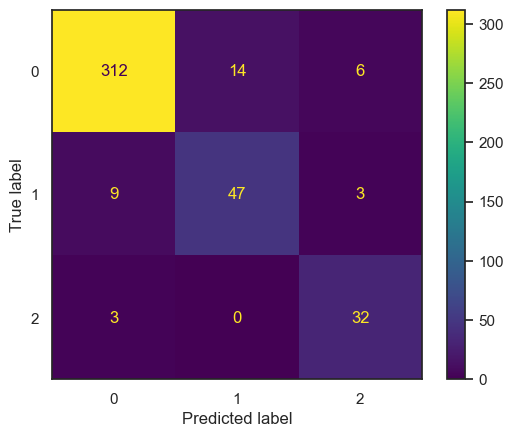

In [39]:
y_pred = best_mlp.predict(X_test_subset)
plt.figure(figsize=(8,4))
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, average=None)
rec = metrics.recall_score(y_test, y_pred, average=None)

model_performance.loc[5] = ["MLP (5 features)", acc, *list(prec), *list(rec)]
model_performance.head(6)

## Summary

Let's review the performance of each of our models.

In [40]:
model_performance.head(6)

,Model,Accuracy,Class 1 precision,Class 2 precision,Class 3 precision,Class 1 recall,Class 2 recall,Class 3 recall
0,Logistic Regression (full df),0.868545,0.927052,0.571429,0.925926,0.918675,0.677966,0.714286
1,Logistic Regression (PCA),0.859155,0.916418,0.576923,0.743590,0.924699,0.508475,0.828571
2,Random Forest (full),0.938967,0.969512,0.833333,0.842105,0.957831,0.847458,0.914286
3,Random Forest (5 features),0.915493,0.948485,0.814815,0.785714,0.942771,0.745763,0.942857
4,MLP (full),0.908451,0.943114,0.725806,0.900000,0.948795,0.762712,0.771429
5,MLP (5 features),0.917840,0.962963,0.770492,0.780488,0.939759,0.796610,0.914286


From this, we can see that we were successfully able to improve the accuracy of our predictions. More importantly however, our class 3 recall was dramatically improved, with a best score on this metric of 0.97 achieved by both the MLP and the random forest subset. Both of these high scores were achieved by narrowing the columns to the five most important in the random forest of the full data set. This reduction in dimensionality of the dat alikely helped limit overfitting and allowed the modesl to better detect the underlying trends in the data, thus improving their performance on the test data.

We were able to use a wide range of models to achieve about 92-95% accuracy on the test data, but these models varied much more significantly in their precision and recall for each class. The primary cause for this is the large number of class 1 instances, which may skew the overall accuracy metric. The main differences in model performance on metrics we are much more interested in, such as class 3 recall (we do not want to miss a diagnosis of a fetus in a pathologic state, even at the risk of misdiagnosing a normal state as pathologic) came from reducing the dimensionality of the data. The logistic regression with PCA performed 10 points better on this metric, the random forest 6, and the MLP with only 5 features had class 3 recall a whole 20 points higher than its counterpart considering all the columns.

Thus, there seems to be a disproportionate significance of the leading features we chose ('MSTV', 'ALTV', 'ASTV', 'Mean', 'Median') in comparison to the others. Consultation with an expert in the domain of cardiocotography and fetal heart rates would be wise, to see what is known about the relationship between these variables and fetal state.

Future work improving these results may want to focus on the selection process for these columns to ensure that the model is truly picking the best subset. One method to consider might be using best-subset selection or bagging/boosting algorithms not considered here. This decision of features seems to be even more important than the slection of models, based on this admittedly small sample size of models. There also remains work to be done further ensuring the best fit model and hyperparameters for the models examined in this analysis, perhaps increasing the cross-validation or paramter spaces searched. As always, the inclusion of more data - both in features and instances - would likely improve the accuracy of the models, though this may not be as certain if the quality of the additional data is inferior to the original data.